# MobileNet V2 & V3 Image Classification

Notebook adapted from the [Image Classification (MobileNetV2, ImageNet)](https://github.com/trekhleb/machine-learning-experiments/blob/master/experiments/image_classification_mobilenet_v2/image_classification_mobilenet_v2.ipynb) and [Rock Paper Scissors (using MobileNetV2 network)](https://github.com/trekhleb/machine-learning-experiments/blob/master/experiments/rock_paper_scissors_mobilenet_v2/rock_paper_scissors_mobilenet_v2.ipynb) notebooks.  
Modified by: Gábor Major  
Last Modified date: 2025-03-21

Import libraries.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import pathlib
import os
import tensorflow.keras.backend as K

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

2025-03-21 13:05:58.061781: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-21 13:05:58.064943: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-21 13:05:58.074939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742562358.091401    2261 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742562358.096257    2261 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742562358.108553    2261 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Python version: 3.12.5
Tensorflow version: 2.19.0
Keras version: 3.9.0


## Load in Datasets
Load the CIFAR 10 and CIFAR 100 datasets to be used to train the models.  
First the CIFAR 10 data set is going to be used to train a model, afterwards the 100 will be used.  
The dataset is originally from [CS Toronto](https://www.cs.toronto.edu/~kriz/cifar.html).  
The 10 version has 60,000 32 by 32 colour images in 10 classes, and the 100 version has 100 classes with 600 images in each.

In [2]:
# See available datasets
tfds.list_builders()

2025-03-21 13:06:00.685854: W external/local_xla/xla/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".


['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'ai2dcaption',
 'aloha_mobile',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asimov_dilemmas_auto_val',
 'asimov_dilemmas_scifi_train',
 'asimov_dilemmas_scifi_val',
 'asimov_injury_val',
 'asimov_multimodal_auto_val',
 'asimov_multimodal_manual_val',
 'asqa',
 'asset',
 'assin2',
 'asu_table_top_converted_externally_to_rlds',
 'austin_buds_dataset_converted_externally_to_rlds',
 'austin_sailor_dataset_converted_externally_to_rlds',
 'austin_sirius_dataset_converted_externally_to_rlds',
 'bair_robot_pushing_small',
 'bc_z',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'berkeley_autolab_ur5',
 'berkeley_cable_routing',
 'berkeley_fanuc_manipulation',
 'berkeley_gnm_cory_hall',
 'berkeley_gnm_recon',
 'berkeley_gnm_sac_son',
 'berkeley_mvp_converted_externally_to_rlds',
 'berkeley_rpt_converted_externally_to_rlds',
 'big_patent',
 'bigearthnet',
 'billsum',
 '

In [76]:
DATASET_NAME = 'cifar100'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [77]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')
print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw train dataset size: 50000 

Raw test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw test dataset size: 10000 



2025-03-21 14:02:18.742828: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [78]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='tmp/cifar100/3.0.2',
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nonde

In [79]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 50000
Number of TEST examples: 10000
Number of label classes: 100


No need to resize images as they are 32 by 32 pixels, which is the minimum for MobileNet.

In [80]:
INPUT_IMG_SIZE = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE = dataset_info.features['image'].shape

print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size: 32
Input image shape: (32, 32, 3)


In [81]:
# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str

In [82]:
print(get_label_name(0))
print(get_label_name(1))

apple
aquarium_fish


## Explore Data

In [83]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

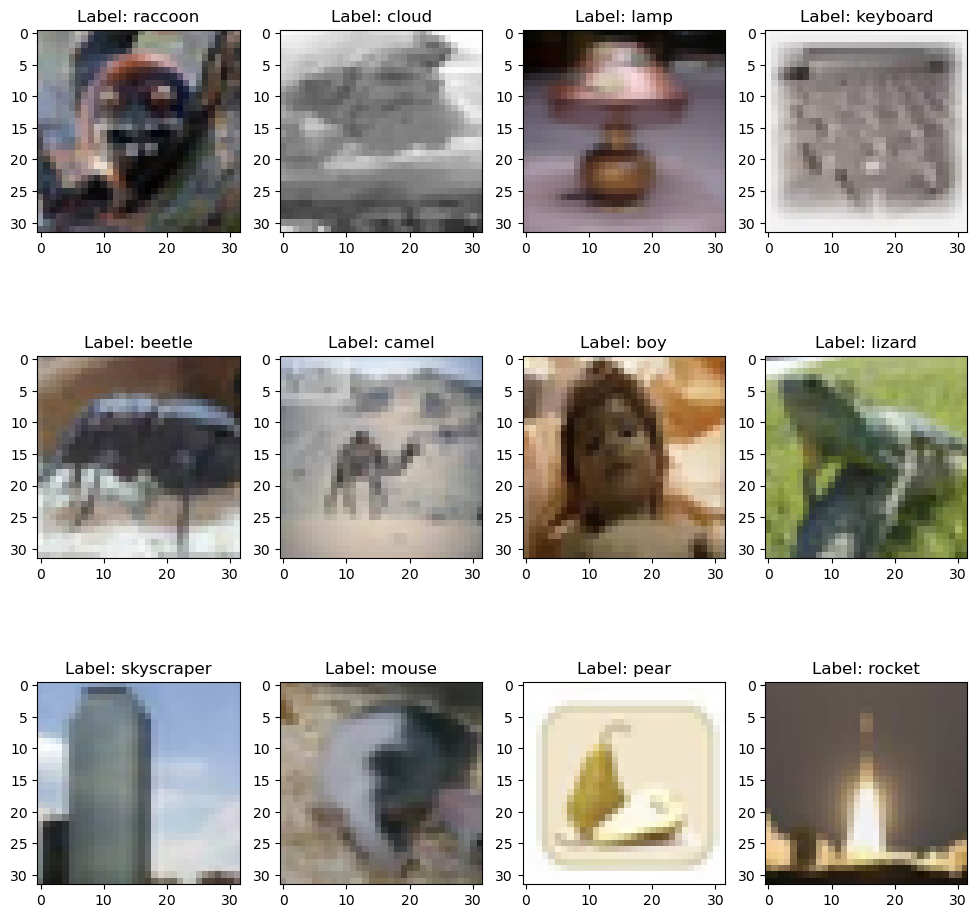

In [84]:
# Explore raw training dataset images.
preview_dataset(dataset_train_raw)

In [85]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train_raw.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 66 

Image shape: (32, 32, 3) 

[[[151 154 145]
  [144 147 135]
  [141 143 134]
  ...
  [ 44  38  39]
  [112 100  96]
  [145 127 120]]

 [[153 156 150]
  [141 144 135]
  [139 142 136]
  ...
  [ 68  59  59]
  [131 113 106]
  [121 101  94]]

 [[163 165 161]
  [150 153 145]
  [147 149 144]
  ...
  [ 75  66  60]
  [101  86  77]
  [ 83  77  73]]

 ...

 [[150 150 162]
  [ 51  52  67]
  [ 46  42  56]
  ...
  [ 60  59  48]
  [ 71  73  56]
  [ 58  62  44]]

 [[146 158 168]
  [ 92 106 116]
  [ 73  77  85]
  ...
  [ 54  55  40]
  [ 59  66  41]
  [ 52  56  28]]

 [[ 92  95 105]
  [ 86  90 100]
  [ 77  74  82]
  ...
  [ 59  61  44]
  [ 44  49  26]
  [ 51  53  27]]]


## Pre-Process Data

In [86]:
def format_example(image, label):
    # Make image colour values to be float.
    image = tf.cast(image, tf.float32)
    # Make image colour values to be in [0..1] range.
    image = image / 255.
    return image, label

In [87]:
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [88]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 66 

Image shape: (32, 32, 3) 

[[[0.5921569  0.6039216  0.5686275 ]
  [0.5647059  0.5764706  0.5294118 ]
  [0.5529412  0.56078434 0.5254902 ]
  ...
  [0.17254902 0.14901961 0.15294118]
  [0.4392157  0.39215687 0.3764706 ]
  [0.5686275  0.49803922 0.47058824]]

 [[0.6        0.6117647  0.5882353 ]
  [0.5529412  0.5647059  0.5294118 ]
  [0.54509807 0.5568628  0.53333336]
  ...
  [0.26666668 0.23137255 0.23137255]
  [0.5137255  0.44313726 0.41568628]
  [0.4745098  0.39607844 0.36862746]]

 [[0.6392157  0.64705884 0.6313726 ]
  [0.5882353  0.6        0.5686275 ]
  [0.5764706  0.58431375 0.5647059 ]
  ...
  [0.29411766 0.25882354 0.23529412]
  [0.39607844 0.3372549  0.3019608 ]
  [0.3254902  0.3019608  0.28627452]]

 ...

 [[0.5882353  0.5882353  0.63529414]
  [0.2        0.20392157 0.2627451 ]
  [0.18039216 0.16470589 0.21960784]
  ...
  [0.23529412 0.23137255 0.1882353 ]
  [0.2784314  0.28627452 0.21960784]
  [0.22745098 0.24313726 0.17254902]]

 [[0.57254905 0.61960787 0.65882355

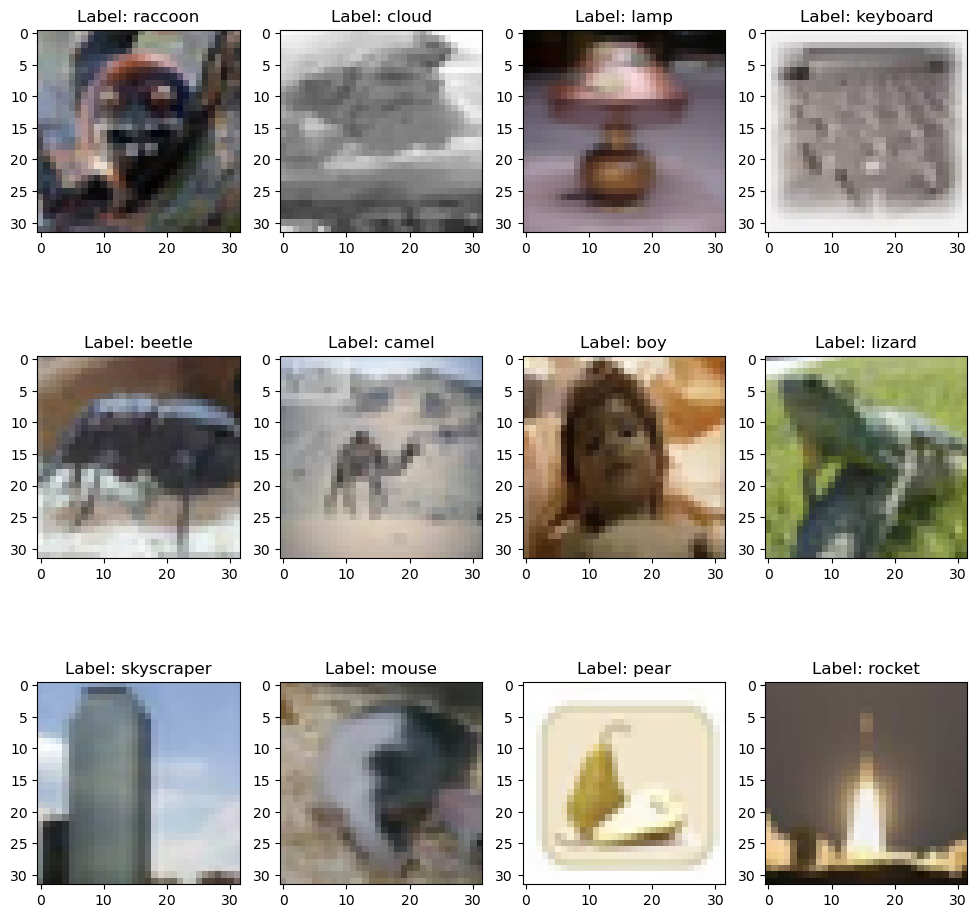

In [89]:
# Explore preprocessed training dataset images.
preview_dataset(dataset_train)

## Shuffle and Batch Data

In [90]:
BATCH_SIZE = 800

dataset_train_shuffled = dataset_train.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_shuffled = dataset_train_shuffled.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_shuffled = dataset_train_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

Label batch shape: (800,) 

Image batch shape: (800, 32, 32, 3) 

Label batch: [68  5 65 32  0  0 70 70 49 45 52 70 29 55 46 90 15 73 47 59  4 87  4 49
 36 79 69 98 12 47  7 14 10 48 18 86 14 76 92 86 73 48 92 85 61 20 13 91
  1 53 64 61 36 41 87 43 60 99 46 57 19 60 92 96 23 86 68 21 71 51 45 72
 49 89 40 44 85 54 27 87 90  9 17  6 51 91 42 39 50 62 36 20 36 68 76 60
 83 85 81 89 40 57 34 57 67 44 57 36 49 56 48  1 53 81 94 96 57 45 92 13
 15 75 65 28 22 51 17 22 63 22 60 16 14  4 90  2 37  7 27 50 43 29 90 49
 13 92 11 19 13 75 38 94 50 26 42 85 26 78 92 82 58 40 80 10 89 73  8 53
 80 82 92 72  8 14 49 77  7 86 38 11 63 21 29 54  6 86 76 68 90 12  1 16
 58 41 76 29 64 17 84 91  8 75 37 18 45 52 94  2  3 69 57 59 48 43 33 24
 95  9 78 26 23 67 71 32 75  0 86 84 24 87 42 68 26 56 36 29 52 29 93  0
 16 13 13 22 92 30 55 12 10 44 26 21 43  5 50 34 99 97 17 23 14 14 90 28
 70 15 37 14 81 81 52  6 65 45 47 94 71 82  7 74 31  2 50 52 42  7 78 25
 73 86  1 41 49 20 40 48  6 60 41 91 75 57 31

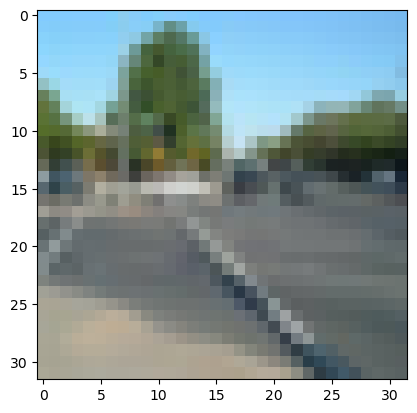

In [91]:
# Debugging the batches using conversion to Numpy arrays.
batches = tfds.as_numpy(dataset_train_shuffled)
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')
    
    for batch_item_index in range(len(image_batch)):
        print('First batch image:', image_batch[batch_item_index], '\n')
        plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Break to shorten the output.
        break
    # Break to shorten the output.
    break


## Load Models
Load in the MobileNet V2 and V3 models from [Keras](https://www.tensorflow.org/api_docs/python/tf/keras/applications).  
These models are based on CNN.  
As the number of classes is different from the base 1000, CIFAR 10 uses 10 and CIFAR 100 uses 100, the model itself is frozen and only the feature extraction is trained.

In [130]:
MODEL_TYPE = 'mobilenet_v3_large'
if MODEL_TYPE == 'mobilenet_v2':
    base_model = tf.keras.applications.MobileNetV2(
      input_shape=INPUT_IMG_SHAPE,
      include_top=False,
      weights='imagenet',
      pooling='avg'
    )
elif MODEL_TYPE == 'mobilenet_v3_small':
    base_model = tf.keras.applications.MobileNetV3Small(
      input_shape=INPUT_IMG_SHAPE,
      include_top=False,
      weights='imagenet',
      pooling='avg'
    )
elif MODEL_TYPE == 'mobilenet_v3_large':
    base_model = tf.keras.applications.MobileNetV3Large(
      input_shape=INPUT_IMG_SHAPE,
      include_top=False,
      weights='imagenet',
      pooling='avg'
    )

In [131]:
base_model.trainable = False

## Analyse the Model

In [132]:
base_model.summary()

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 32, 32, 3) │          0 │ input_layer_10[0… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 16, 16,    │        432 │ rescaling_3[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 16, 16,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 16, 16,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        144 │ activation_56[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_47 (ReLU)     │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        256 │ re_lu_47[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 16, 16,    │          0 │ activation_56[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_48 (ReLU)     │ (None, 16, 16,    │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 17, 17,    │          0 │ re_lu_48[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

## Add Classification Head

In [133]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)
))

In [134]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        96,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,092,452 (11.80 MB)

 Trainable params: 96,100 (375.39 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

## Compiling Model

In [135]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

## Training the Models with CIFAR 10

In [136]:
initial_epochs = 20
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE if NUM_TEST_EXAMPLES // BATCH_SIZE else 1

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 62
validation_steps: 12


In [137]:
training_history = model.fit(
    x=dataset_train_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 334ms/step - accuracy: 0.0111 - loss: 7.4007 - val_accuracy: 0.0252 - val_loss: 4.7113
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - accuracy: 0.0130 - loss: 5.0190 - val_accuracy: 0.0334 - val_loss: 4.5612
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 345ms/step - accuracy: 0.0186 - loss: 4.6729 - val_accuracy: 0.0418 - val_loss: 4.5246
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 344ms/step - accuracy: 0.0231 - loss: 4.5831 - val_accuracy: 0.0416 - val_loss: 4.5085
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - accuracy: 0.0261 - loss: 4.5479 - val_accuracy: 0.0395 - val_loss: 4.5042
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.0268 - loss: 4.5408 - val_accuracy: 0.0352 - val_loss: 4.5051
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.0290 - loss: 4.5340 - val_accuracy: 0.0330 - val_loss: 4.5004
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 363ms/step - accuracy: 0.0280 - loss: 4.5316 - val_accu

In [138]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

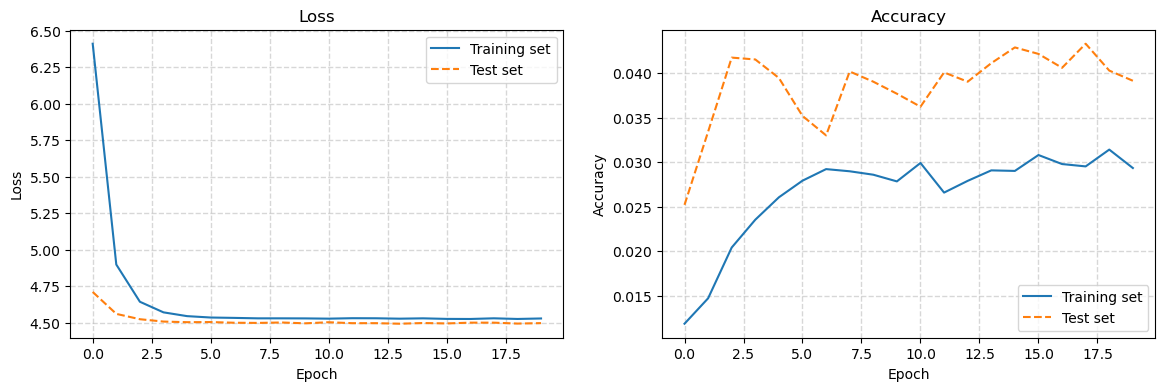

In [139]:
render_training_history(training_history)

## Fine Tune Model

In [140]:
# Un-freeze the top layers of the models
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  188


In [141]:
# Freeze all the layers before the specified layer
for layer in base_model.layers[:round(len(base_model.layers) * 0.05)]:
    layer.trainable =  False
    
# Compile the model using a much-lower training rate.
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer = adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        96,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,092,452 (11.80 MB)

 Trainable params: 3,067,156 (11.70 MB)

 Non-trainable params: 25,296 (98.81 KB)

In [142]:
# The number of additional epochs during which we're going to fine tune the model.
fine_tuning_epochs = 10

In [143]:
training_history_fine = model.fit(
    x=dataset_train_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs + fine_tuning_epochs,
    initial_epoch=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 21/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.0162 - loss: 4.6685 - val_accuracy: 0.0150 - val_loss: 6.4522
Epoch 22/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.0486 - loss: 4.4617 - val_accuracy: 0.0099 - val_loss: 5.7148
Epoch 23/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.0824 - loss: 4.2483 - val_accuracy: 0.0120 - val_loss: 7.2985
Epoch 24/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.1071 - loss: 4.0533 - val_accuracy: 0.0113 - val_loss: 7.4375
Epoch 25/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.1323 - loss: 3.8730 - val_accuracy: 0.0120 - val_loss: 7.1843
Epoch 26/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.1578 - loss: 3.7210 - val_accuracy: 0.0086 - val_loss: 7.0858
Epoch 27/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.1787 - loss: 3.5846 - val_accuracy: 0.0102 - val_loss: 8.4749
Epoch 28/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.1922 - loss: 3.4708 - val_accuracy: 0.0113 - 

In [144]:
def render_training_history_fine(training_history, training_history_fine):
    loss = training_history.history['loss'] + training_history_fine.history['loss']
    val_loss = training_history.history['val_loss'] + training_history_fine.history['val_loss']
    
    accuracy = training_history.history['accuracy'] + training_history_fine.history['accuracy']
    val_accuracy = training_history.history['val_accuracy'] + training_history_fine.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.plot(
    [initial_epochs, initial_epochs], 
    plt.ylim(),
    label='Start Fine Tuning',
    linestyle='--'
    )
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.plot(
    [initial_epochs, initial_epochs], 
    plt.ylim(),
    label='Start Fine Tuning',
    linestyle='--'
    )
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    
    plt.show()

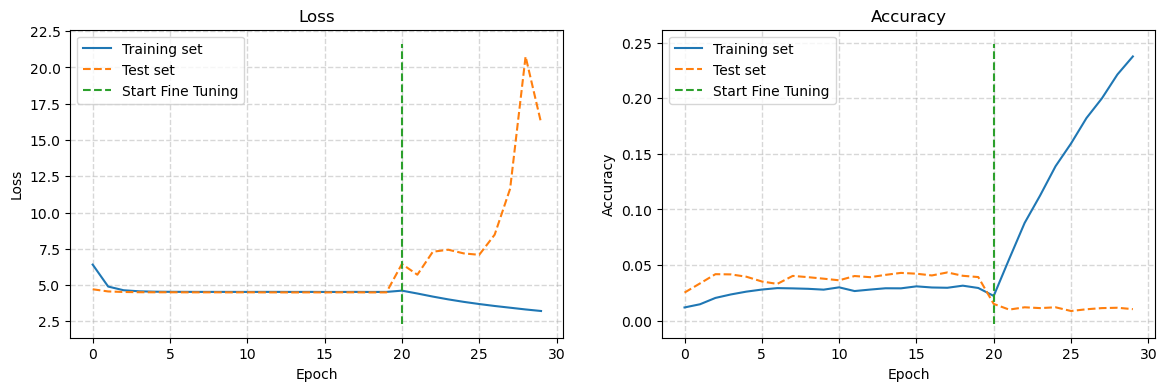

In [145]:
render_training_history_fine(training_history, training_history_fine)

## Evaluate Model

In [146]:
def eval_model(model):
    train_loss, train_accuracy = model.evaluate(
        x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
    )
    
    test_loss, test_accuracy = model.evaluate(
        x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
    )
    print('Training loss: ', train_loss)
    print('Training accuracy: ', train_accuracy)
    print('\n')
    print('Test loss: ', test_loss)
    print('Test accuracy: ', test_accuracy)

In [147]:
eval_model(model)

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.0098 - loss: 16.2303
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.0101 - loss: 16.2583
Training loss:  16.23200798034668
Training accuracy:  0.010040000081062317


Test loss:  16.2645263671875
Test accuracy:  0.010400000028312206


## Save Model

In [148]:
model.save(f'models/{DATASET_NAME}_{MODEL_TYPE}.keras')